In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import warnings
import os
from keras import models
from keras.utils import plot_model
from keras.layers import Dropout, Dense, GRU, LSTM, Flatten
import matplotlib.pyplot as plt
from Const import *
warnings.filterwarnings('ignore')

In [2]:
### Setting simulation year and learning period
SimulationYear = 2016
Period = 10
LearningYearStart = SimulationYear - Period + 1

In [3]:
n_steps_in = 20
n_steps_out = 1
output_features = 2

In [4]:
### Stock symbol
code = SYMBOL
### Prepared dataset with indicators
PreparedDatasetPath = "Datasets_with_Indicators/"+code+".csv"
### Dataset for backtesting simulation path
SimulationDatasetPath = "SimulationDatasets/Classification/"+code+"_"+str(SimulationYear)+".csv"
### Creating directory for learning data
LearningDataPath = "ClassificationData/"+code+"_"+str(SimulationYear)+"_"+str(n_steps_in)+"Days"
if not os.path.exists(LearningDataPath):
   os.makedirs(LearningDataPath)

In [5]:
# LR = 0.0005
BATCH_SIZE = 100
N_EPOCH = 22

In [6]:
def get_simulation_data():
    org_dataset = pd.read_csv(PreparedDatasetPath, parse_dates=True)
    org_dataset.Date = pd.to_datetime(org_dataset.Date, dayfirst=True)
    org_dataset = org_dataset.set_index(org_dataset.Date)
    org_dataset = org_dataset.drop("ZigZag", axis='columns')

    org_dataset = org_dataset.drop("Return_rate", axis='columns')
    org_dataset = org_dataset.drop("RSI_7", axis='columns')
    org_dataset = org_dataset.drop("RSI_14", axis='columns')
    org_dataset = org_dataset.drop("MA_7", axis='columns')
    org_dataset = org_dataset.drop("MA_14", axis='columns')

    sim_dataset = org_dataset[str(SimulationYear)+"-01-02":str(SimulationYear)+"-12-31"]
    sim_dataset = sim_dataset.reset_index(drop=True)
    sim_dataset.to_csv(SimulationDatasetPath, index=False)

    return sim_dataset, len(sim_dataset)

## 1. Przygotowanie danych

In [2115]:
dataset = pd.read_csv(PreparedDatasetPath, parse_dates=True)
dataset.Date = pd.to_datetime(dataset.Date, dayfirst=True)
dataset = dataset.set_index(dataset.Date)
dataset = dataset.drop("Date", axis='columns')
dataset

,Open,High,Low,Close,ZigZag,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,,
2000-01-18,1.01110,1.01550,1.00720,1.01400,1,1.002769,36.106221,41.847381,1.019714,1.024307
2000-01-19,1.01410,1.01650,1.00850,1.01170,1,0.997732,32.411299,39.100201,1.016786,1.023271
2000-01-20,1.01160,1.01880,1.00730,1.01690,1,1.005140,46.777470,47.492823,1.014700,1.022393
2000-01-21,1.01660,1.01930,1.00500,1.00870,1,0.991936,33.627629,38.485863,1.012514,1.020707
2000-01-23,1.00280,1.00450,1.00260,1.00430,1,0.995638,28.595350,34.684738,1.011386,1.018836
...,...,...,...,...,...,...,...,...,...,...
2022-12-07,1.04670,1.05493,1.04427,1.05114,0,1.004223,64.103095,64.267401,1.050111,1.043287
2022-12-08,1.05115,1.05643,1.04892,1.05551,0,1.004157,69.392195,66.614241,1.052003,1.045037
2022-12-09,1.05549,1.05878,1.05032,1.05325,0,0.997859,63.726914,64.263552,1.052074,1.045859


In [2116]:
dataset = dataset[str(LearningYearStart)+"-01-02":str(SimulationYear)+"-12-31"]
dataset

,Open,High,Low,Close,ZigZag,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,,
2007-01-02,1.32330,1.32960,1.32210,1.32790,1,1.003628,72.303596,63.224289,1.318029,1.316493
2007-01-03,1.32800,1.32890,1.31460,1.31630,1,0.991264,46.514110,50.903553,1.318729,1.317000
2007-01-04,1.31640,1.31790,1.30750,1.30780,1,0.993543,35.645093,44.118963,1.318243,1.316829
2007-01-05,1.30770,1.31040,1.29800,1.30010,1,0.994112,28.585627,39.042413,1.316271,1.315236
2007-01-07,1.30100,1.30100,1.29840,1.29920,1,0.999308,27.833926,38.485008,1.313329,1.313871
...,...,...,...,...,...,...,...,...,...,...
2016-12-26,1.04520,1.04673,1.04396,1.04533,0,1.000144,42.639925,39.124576,1.043017,1.047456
2016-12-27,1.04534,1.04630,1.04319,1.04612,0,1.000756,45.369273,40.152547,1.043859,1.046855
2016-12-28,1.04601,1.04793,1.03717,1.04138,0,0.995469,34.033448,36.202408,1.044194,1.045226


In [2117]:
sim_dataset, TestLength= get_simulation_data()
sim_dataset

,Date,Open,High,Low,Close
0,2016-01-03,1.08549,1.08595,1.08440,1.08516
1,2016-01-04,1.08516,1.09462,1.07811,1.08232
2,2016-01-05,1.08230,1.08386,1.07102,1.07501
3,2016-01-06,1.07500,1.07992,1.07143,1.07764
4,2016-01-07,1.07765,1.09394,1.07701,1.09255
...,...,...,...,...,...
305,2016-12-26,1.04520,1.04673,1.04396,1.04533
306,2016-12-27,1.04534,1.04630,1.04319,1.04612
307,2016-12-28,1.04601,1.04793,1.03717,1.04138
308,2016-12-29,1.04139,1.06522,1.04136,1.05649


In [2118]:
X_value = pd.DataFrame(dataset.iloc[:, :])
X_value = X_value.drop("ZigZag", axis='columns')
y_value = pd.DataFrame(dataset.ZigZag)

In [2119]:
n_features = X_value.shape[1]
print(n_features)

9


In [2120]:
X_value

,Open,High,Low,Close,Return_rate,RSI_7,RSI_14,MA_7,MA_14
Date,,,,,,,,,
2007-01-02,1.32330,1.32960,1.32210,1.32790,1.003628,72.303596,63.224289,1.318029,1.316493
2007-01-03,1.32800,1.32890,1.31460,1.31630,0.991264,46.514110,50.903553,1.318729,1.317000
2007-01-04,1.31640,1.31790,1.30750,1.30780,0.993543,35.645093,44.118963,1.318243,1.316829
2007-01-05,1.30770,1.31040,1.29800,1.30010,0.994112,28.585627,39.042413,1.316271,1.315236
2007-01-07,1.30100,1.30100,1.29840,1.29920,0.999308,27.833926,38.485008,1.313329,1.313871
...,...,...,...,...,...,...,...,...,...
2016-12-26,1.04520,1.04673,1.04396,1.04533,1.000144,42.639925,39.124576,1.043017,1.047456
2016-12-27,1.04534,1.04630,1.04319,1.04612,1.000756,45.369273,40.152547,1.043859,1.046855
2016-12-28,1.04601,1.04793,1.03717,1.04138,0.995469,34.033448,36.202408,1.044194,1.045226


In [2121]:
y_value = tf.keras.utils.to_categorical(y_value)

In [2122]:
y_value

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [2123]:
# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
X_scale_dataset = X_scaler.fit_transform(X_value)
dump(X_scaler, open(LearningDataPath+"/X_scaler.pkl", "wb"))

In [2124]:
def get_X_y(X_data, y_data):
    X = list()
    y = list()

    length = len(X_data)
    for i in range(0, length-n_steps_in, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        # y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, :]
        y_value = y_data[i + n_steps_in]
        if len(X_value) == n_steps_in and len(y_value) == output_features:
            X.append(X_value)
            y.append(y_value)

    return np.array(X), np.array(y)

In [2125]:
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

In [2126]:
def split_train_test(data):
    train_size = len(X) - TestLength
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [2127]:
X, y = get_X_y(X_scale_dataset, y_value)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
train_predict_index, test_predict_index, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('index_train shape:', train_predict_index.shape)
print('index_test shape:', test_predict_index.shape)

X shape:  (3094, 20, 9)
y shape:  (3094, 2)
X_train shape:  (2784, 20, 9)
y_train shape:  (2784, 2)
X_test shape:  (310, 20, 9)
y_test shape:  (310, 2)
index_train shape: (2784,)
index_test shape: (310,)


In [2128]:
train_predict_index

DatetimeIndex(['2007-01-25', '2007-01-26', '2007-01-28', '2007-01-29',
               '2007-01-30', '2007-01-31', '2007-02-01', '2007-02-02',
               '2007-02-04', '2007-02-05',
               ...
               '2015-12-20', '2015-12-21', '2015-12-22', '2015-12-23',
               '2015-12-24', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='Date', length=2784, freq=None)

In [2129]:
test_predict_index

DatetimeIndex(['2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06',
               '2016-01-07', '2016-01-08', '2016-01-10', '2016-01-11',
               '2016-01-12', '2016-01-13',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=310, freq=None)

In [2130]:
np.save(LearningDataPath+"/X_train.npy", X_train)
np.save(LearningDataPath+"/y_train.npy", y_train)
np.save(LearningDataPath+"/X_test.npy", X_test)
np.save(LearningDataPath+"/y_test.npy", y_test)
np.save(LearningDataPath+"/train_predict_index.npy", train_predict_index)
np.save(LearningDataPath+"/test_predict_index.npy", test_predict_index)

## LSTM

In [2131]:
# Load data
X_train = np.load(LearningDataPath+"/X_train.npy", allow_pickle=True)
y_train = np.load(LearningDataPath+"/y_train.npy", allow_pickle=True)
X_test = np.load(LearningDataPath+"/X_test.npy", allow_pickle=True)
y_test = np.load(LearningDataPath+"/y_test.npy", allow_pickle=True)

In [2132]:
input_dim = X_train.shape[1]     # 7
input_feature_size = X_train.shape[2]  # 5
output_dim = y_train.shape[1]    # 1

In [2133]:
print(output_dim)

2


In [2134]:
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [2135]:
# ## 61.92% ###
#
# # def basic_LSTM(input_dim, output_dim, input_feature_size):
# #     model = models.Sequential()
# #     model.add(LSTM(units=63, return_sequences=True, activation='relu', input_shape=(input_dim, input_feature_size)))
# #     model.add(Dropout(0.2))
# #     model.add(LSTM(250, return_sequences=False))
# #     model.add(Dropout(0.2))
# #     model.add(Dense(output_dim, activation='softmax'))
# #
# #     model.compile(optimizer='adam',
# #               loss='categorical_crossentropy',
# #               metrics=['accuracy'])
# #     history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, verbose=2, shuffle=False)
# #
# #     return model, history

In [2136]:
# # def basic_LSTM(input_dim, output_dim, input_feature_size):
# #     model = models.Sequential()
# #     model.add(LSTM(units=50, return_sequences=True, input_shape=(input_dim, input_feature_size)))
# #     # model.add(Dropout(0.20))
# #     model.add(LSTM(40, return_sequences=False))
# #     model.add(Dropout(0.20))
# #     model.add(Dense(output_dim, activation='softmax'))
# #
# #     model.compile(optimizer='adam',
# #               loss='categorical_crossentropy',
# #               metrics=['accuracy'])
# #     history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, verbose=2, shuffle=False)
# #
# #     return model, history

In [2137]:
def basic_LSTM(input_dim, output_dim, input_feature_size):
    model = models.Sequential()
    model.add(LSTM(units=64, return_sequences=True, 
                   input_shape=(input_dim, input_feature_size)))
    model.add(LSTM(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation='softmax'))
    
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    return model, history

In [2138]:
model, history = basic_LSTM(input_dim, output_dim, input_feature_size)
plot_model(model, to_file='Figures/Others/LSTM_Model.png')
print(model.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/22
28/28 - 5s - loss: 0.6948 - accuracy: 0.5205 - val_loss: 0.7108 - val_accuracy: 0.5065 - 5s/epoch - 173ms/step
Epoch 2/22
28/28 - 1s - loss: 0.6756 - accuracy: 0.5851 - val_loss: 0.7227 - val_accuracy: 0.4484 - 525ms/epoch - 19ms/step
Epoch 3/22
28/28 - 1s - loss: 0.6658 - accuracy: 0.6049 - val_loss: 0.7065 - val_accuracy: 0.4581 - 529ms/epoch - 19ms/step
Epoch 4/22
28/28 - 1s - loss: 0.6554 - accuracy: 0.6225 - val_loss: 0.7035 - val_accuracy: 0.4871 - 531ms/epoch - 19ms/step
Epoch 5/22
28/28 - 0s - loss: 0.6464 - accuracy: 0.6462 - val_loss: 0.6995 - val_accuracy: 0.4806 - 495ms/epoch - 18ms/step
Epoch 6/22
28/28 - 1s - loss: 0.6389 - accuracy: 0.6548 - val_loss: 0.6840 - val_accuracy: 0.5194 - 546ms/epoch - 19ms/step
Epoch 7/22
28/28 - 1s - loss: 0.6292 - accuracy: 0.6674 - val_loss: 0.6722 - val_accuracy: 0.5258 - 562ms/epo

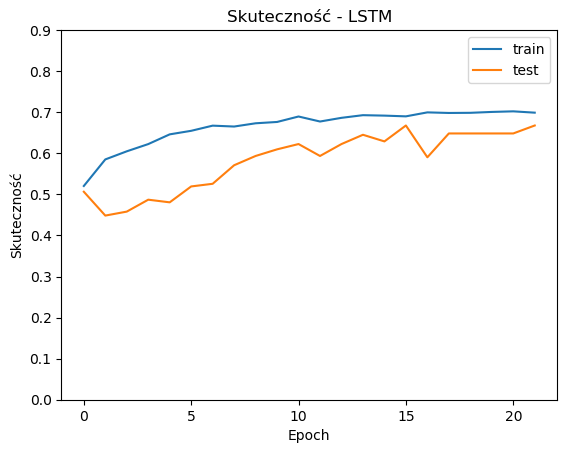

In [2139]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.title("Skuteczność - LSTM")
plt.xlabel("Epoch")
plt.ylabel("Skuteczność")
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, 1, step=0.1))
plt.legend()
plt.show()

In [2140]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 0s 5ms/step - loss: 0.6085 - accuracy: 0.6677
Test loss: 0.6084579825401306
Test accuracy: 0.6677419543266296


In [2141]:
print("Maksymalna skuteczność to: {:.2f}%".format((max(history.history["val_accuracy"])*100)))

Maksymalna skuteczność to: 66.77%


In [2142]:
model.save(LearningDataPath+"/LSTM_"+str(n_steps_in)+"Days.h5")
model.save(LearningDataPath+"/LSTM_"+str(n_steps_in)+"Days"+str(round(score[1]*100))+"p.h5")

## GRU

In [7]:
# Load data
X_train = np.load(LearningDataPath+"/X_train.npy", allow_pickle=True)
y_train = np.load(LearningDataPath+"/y_train.npy", allow_pickle=True)
X_test = np.load(LearningDataPath+"/X_test.npy", allow_pickle=True)
y_test = np.load(LearningDataPath+"/y_test.npy", allow_pickle=True)

In [8]:
input_dim = X_train.shape[1]     # 7
input_feature_size = X_train.shape[2]  # 5
output_dim = y_train.shape[1]    # 1

In [9]:
def basic_GRU(input_dim, output_dim, input_feature_size):
    model = models.Sequential()
    model.add(GRU(units=64, return_sequences=True, input_shape=(input_dim, input_feature_size)))
    model.add(GRU(units=32))
    model.add(Dropout(0.2))
    model.add(Dense(output_dim, activation='softmax'))
    plot_model(model, to_file='Figures/Others/GRU_Model.png')

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, verbose=2,
                        shuffle=False, validation_data=(X_test, y_test))


    return model, history

In [10]:
model, history = basic_GRU(input_dim, output_dim, input_feature_size)
plot_model(model, to_file='Figures/Others/GRU_Model.png')
print(model.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/22
28/28 - 5s - loss: 0.6701 - accuracy: 0.6128 - val_loss: 0.7089 - val_accuracy: 0.4935 - 5s/epoch - 177ms/step
Epoch 2/22
28/28 - 0s - loss: 0.6427 - accuracy: 0.6451 - val_loss: 0.7121 - val_accuracy: 0.5226 - 448ms/epoch - 16ms/step
Epoch 3/22
28/28 - 0s - loss: 0.6270 - accuracy: 0.6688 - val_loss: 0.6793 - val_accuracy: 0.5516 - 448ms/epoch - 16ms/step
Epoch 4/22
28/28 - 0s - loss: 0.6127 - accuracy: 0.6868 - val_loss: 0.6679 - val_accuracy: 0.5645 - 490ms/epoch - 17ms/step
Epoch 5/22
28/28 - 0s - loss: 0.6015 - accuracy: 0.6983 - val_loss: 0.6485 - val_accuracy: 0.6000 - 435ms/epoch - 16ms/step
Epoch 6/22
28/28 - 0s - loss: 0.5979 - accuracy: 0.6976 - val_loss: 0.6427 - val_accuracy: 0.6129 - 455ms/epoch - 16ms/step
Epoch 7/22
28/28 - 0s - loss: 0.5963 - accuracy: 0.6997 - val_loss: 0.6357 - val_accuracy: 0.6258 - 451ms/epo

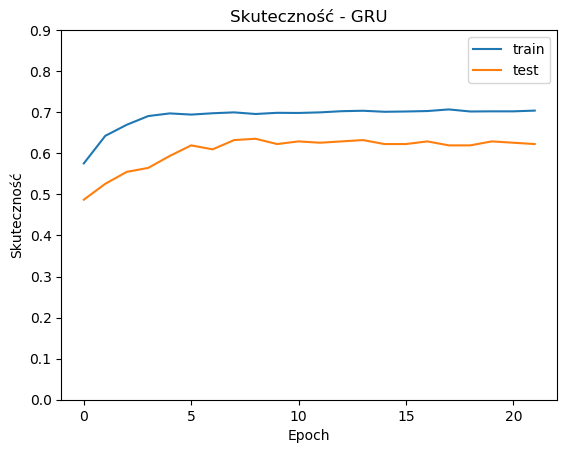

In [2147]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.title("Skuteczność - GRU")
plt.xlabel("Epoch")
plt.ylabel("Skuteczność")
plt.xticks(np.arange(0, N_EPOCH, step=5))
plt.yticks(np.arange(0, 1, step=0.1))
plt.legend()
plt.show()

In [2148]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 0s 5ms/step - loss: 0.6192 - accuracy: 0.6226
Test loss: 0.6191628575325012
Test accuracy: 0.6225806474685669


In [2149]:
print("Maksymalna skuteczność to: {:.2f}%".format((max(history.history["val_accuracy"])*100)))

Maksymalna skuteczność to: 63.55%


In [2150]:
model.save(LearningDataPath+"/GRU_"+str(n_steps_in)+"Days.h5")
model.save(LearningDataPath+"/GRU_"+str(n_steps_in)+"Days"+str(round(score[1]*100))+"p.h5")